In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = True
log_wandb = False

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "tab_ddpm_concat"
gp = True
gp_multiply = False
random_seed = 1
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/tab_ddpm_concat/1"
param_index = 3
allow_same_prediction = True
log_wandb = False


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/tab_ddpm_concat/1


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7a9f0d8ca320>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-03 06:20:57.973451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 06:20:57.973508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 06:20:57.975128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found 

In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../contraceptive/_cache_test/tab_ddpm_concat/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'loss_balancer_beta': 0.6806661100374879,
 'loss_balancer_r': 0.9427716710925113,
 'tf_pma_low': 4,
 'grad_loss_fn': <function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.7494458230986923,
 'gradient_penalty_mode': {'gradient_penalty': True,
  'forward_once': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'dataset_size': 2048,
 'batch_size': 4,
 'epochs': 100,
 'lr_mul': 0.07424782199493057,
 'n_warmup_steps': 104,
 'Optim': functools.partial(<class 'torch.optim.adamw.AdamW'>, amsgrad=True),
 'fixed_role_model': 'tab_ddpm_concat',
 'd_model': 128,
 'attn_activation': ml_utility_loss.activations.LeakyHardtanh,
 'tf_d_inner': 512,
 'tf_n_layers_enc': 3,
 'tf_n_head': 32,
 'tf_activation': torch.nn.modul

In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../contraceptive/_cache/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache4/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/contraceptive [80, 20]
Caching in ../../../../contraceptive/_cache5/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/contraceptive [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>
[*] Embedding False True
['tab_ddpm_concat'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

7827841

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 10]             --
├─Adapter: 1-1                                                         [2, 1179, 10]             --
│    └─Sequential: 2-1                                                 [2, 1179, 128]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           11,264
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 1179, 1024]           1,049,600
│    │    │    └─Softsign: 4-4                                         [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=allow_same_prediction,
    wandb=wandb if log_wandb else None,
    study_name=study_name,
    **params
)

g_loss_mul 0.1
Epoch 0
Train loss {'avg_role_model_loss': 0.01341511887658271, 'avg_role_model_std_loss': 0.24023109539175563, 'avg_role_model_mean_pred_loss': 0.000575269428866676, 'avg_role_model_g_mag_loss': 0.004837815280916402, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.015502669336274266, 'n_size': 320, 'n_batch': 80, 'duration': 86.60318899154663, 'duration_batch': 1.082539862394333, 'duration_size': 0.27063496559858324, 'avg_pred_std': 0.11721891383640468}
Val loss {'avg_role_model_loss': 0.018764166883192955, 'avg_role_model_std_loss': 0.7378902015632776, 'avg_role_model_mean_pred_loss': 0.0008810971392904321, 'avg_role_model_g_mag_loss': 0.006337779993191362, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.02165449762251228, 'n_size': 80, 'n_batch

Val loss {'avg_role_model_loss': 0.002168826656998135, 'avg_role_model_std_loss': 1.1961765073471269, 'avg_role_model_mean_pred_loss': 3.218722386769124e-06, 'avg_role_model_g_mag_loss': 0.008597346721217036, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022069613172789105, 'n_size': 80, 'n_batch': 20, 'duration': 19.133681535720825, 'duration_batch': 0.9566840767860413, 'duration_size': 0.23917101919651032, 'avg_pred_std': 0.03733009579591453}
Epoch 8
Train loss {'avg_role_model_loss': 0.001353109241972561, 'avg_role_model_std_loss': 0.2765715855718042, 'avg_role_model_mean_pred_loss': 2.087236364796191e-06, 'avg_role_model_g_mag_loss': 0.008927629049867391, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013720194954657927, 'n_size': 320, 'n_batch': 80, 'd

Train loss {'avg_role_model_loss': 0.0007071739214552508, 'avg_role_model_std_loss': 0.11358937955730664, 'avg_role_model_mean_pred_loss': 8.504173889859433e-07, 'avg_role_model_g_mag_loss': 0.009156818711198866, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007155208293625037, 'n_size': 320, 'n_batch': 80, 'duration': 85.8247458934784, 'duration_batch': 1.07280932366848, 'duration_size': 0.26820233091712, 'avg_pred_std': 0.08828951774630696}
Val loss {'avg_role_model_loss': 0.0027607452910160648, 'avg_role_model_std_loss': 0.5599186637941784, 'avg_role_model_mean_pred_loss': 1.3696136823915239e-05, 'avg_role_model_g_mag_loss': 0.00771399496588856, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0028348844876745715, 'n_size': 80, 'n_batch': 20, 'duration': 18

Val loss {'avg_role_model_loss': 0.002864245133969234, 'avg_role_model_std_loss': 0.4667397131830512, 'avg_role_model_mean_pred_loss': 1.4686058315405149e-05, 'avg_role_model_g_mag_loss': 0.007691610814072191, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002942165515560191, 'n_size': 80, 'n_batch': 20, 'duration': 19.0608127117157, 'duration_batch': 0.9530406355857849, 'duration_size': 0.23826015889644622, 'avg_pred_std': 0.052058699540793896}
Epoch 23
Train loss {'avg_role_model_loss': 0.00043534455560347853, 'avg_role_model_std_loss': 0.07720435771696674, 'avg_role_model_mean_pred_loss': 3.792708702435137e-07, 'avg_role_model_g_mag_loss': 0.009331031411420554, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00044047548610706146, 'n_size': 320, 'n_batch': 80

Train loss {'avg_role_model_loss': 0.0004039141500470578, 'avg_role_model_std_loss': 0.09576162853820311, 'avg_role_model_mean_pred_loss': 1.8995679496383588e-07, 'avg_role_model_g_mag_loss': 0.009361328079830856, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00040872053962175413, 'n_size': 320, 'n_batch': 80, 'duration': 86.09150242805481, 'duration_batch': 1.076143780350685, 'duration_size': 0.26903594508767126, 'avg_pred_std': 0.09370959255611525}
Val loss {'avg_role_model_loss': 0.0027511596577824093, 'avg_role_model_std_loss': 0.6731958146176111, 'avg_role_model_mean_pred_loss': 1.417353958319545e-05, 'avg_role_model_g_mag_loss': 0.007637712243013084, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0028271504568692764, 'n_size': 80, 'n_batch': 20, 'durati

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
#torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

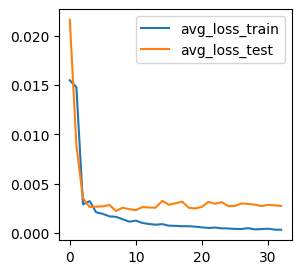

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  \
tab_ddpm_concat        0.021014        0.035295   0.00138       1.530448   

                 grad_mae  grad_mape  grad_rmse  mean_pred_loss  \
tab_ddpm_concat  0.053249   0.899056   0.066081        0.000001   

                 pred_duration  pred_mae  pred_mape  pred_rmse  pred_std  \
tab_ddpm_concat       1.906904  0.029848   0.068946   0.037142  0.059308   

                 std_loss  total_duration  
tab_ddpm_concat  0.007086        3.437351

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_test/tab_ddpm_concat/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tab_ddpm_concat': 0.42752763501982344}


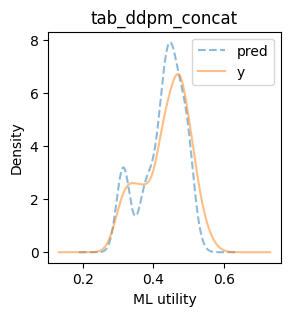

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

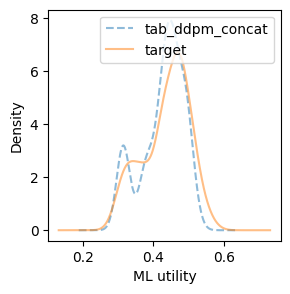

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

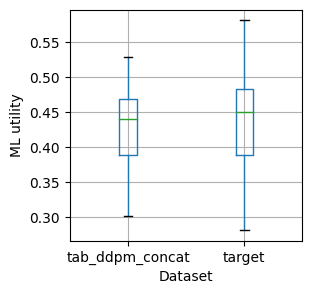

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

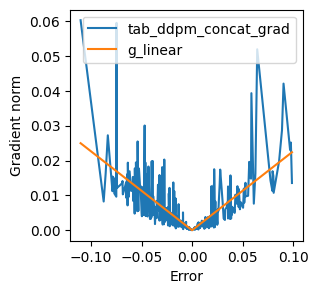

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""